In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Basics and Notes I took from the Original Paper of SRCNN

***feel free to skip this part.***


- Bilinear / [[Bicubic interpolation]] can indeed increase the size of the image but the resulting image will be blurred.
- [[Bicubic interpolation]] can indeed produce larger images by interpolating between known data points, but the resulting images may lack fine details and appear blurred compared to the original high-resolution images. This blurring effect occurs because [[Bicubic interpolation]] smooths out transitions between pixels, which can result in a loss of sharpness and detail.

- Deep learning-based super-resolution methods aim to address this limitation by learning to generate more realistic and detailed super-resolved images, capturing finer details and textures that may be lost with [[Bicubic interpolation]].


- Image super resolution is the task of obtaining high resolution images from low resolution images.
-  In terms of deep learning and computer vision, the **low resolution (LR)** image is the input feature. Then we train our SRCNN(super resolution CNN) to learn the features of the low resolution input image and map it to the corresponding features of a **high resolution (HR)** image (which is the label).

### Approach:
- The main aim here is to obtain a high resolution image from a low resolution image.
- We have a low resolution image which we upscale using bicubic interpolation , which then gives us a blurry image. Let it be **Y** 
- Now, we want to obtain the high resolution counterpart of the same image, X, which is the ground truth. We can also call X as F(Y) and we need to learn the mapping F. F means when we provide Y to F then it should give us X.

- **It requires three operations:**
	- Patch extraction and representation: This operation extracts (overlapping) patches from the low resolution image Y and represents each patch as a high-dimensional vector. These vectors comprise a set of feature maps, of which the number equals to the dimensionality of the vectors. 
	-  Non-linear mapping: This operation nonlinearly maps each high-dimensional vector onto another high-dimensional vector. Each mapped vector is conceptually the representation of a high-resolution patch. These vectors comprise another set of feature maps.
	- Reconstruction: This operation aggregates the above high-resolution patch-wise representations to generate the final high-resolution image. This image is expected to be similar to the ground truth X.
	

#### Patch Extraction:
Patches : small, overlapping regions of the image

- So, we first densely extract patches from the low resolution input image, then they are represented using a set of pretrained bases such as principal component analysis , which basically captures the essential information from each patch in a compressed form. 
- The patch representation step is equivalent to convolving the image with a set of filters, where each filter serves as a basis for the convolution operation. 
- F1(Y)=max(0,W<sub>1​</sub>​∗Y+B<sub>1​</sub>​)
	-  Y is the input image.
	- W<sub>1​</sub> represents the filters. W<sub>1​</sub> contains n<sub>1</sub> filters of c x f<sub>1</sub> x f<sub>1</sub>
	- B<sub>1​</sub>​ represents the biases.
	- ∗ denotes the convolution operation.
	- max(0,x) is the Rectified Linear Unit (ReLU) activation function
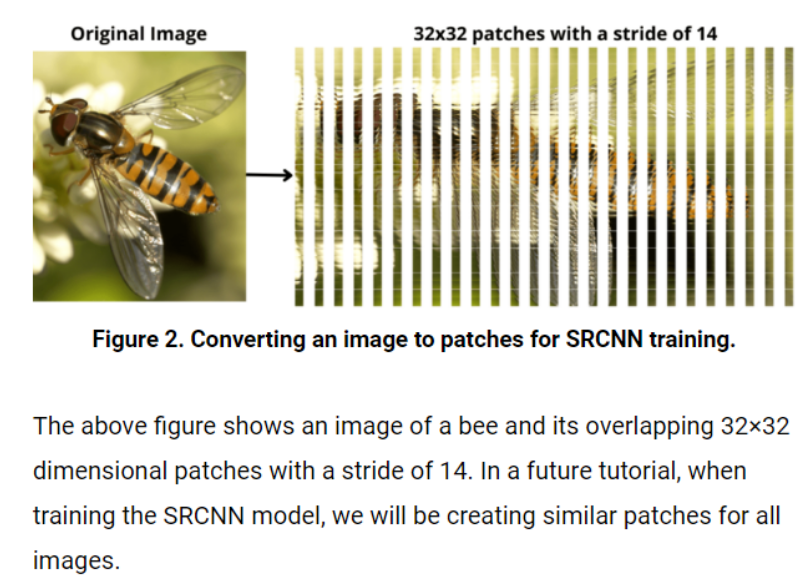

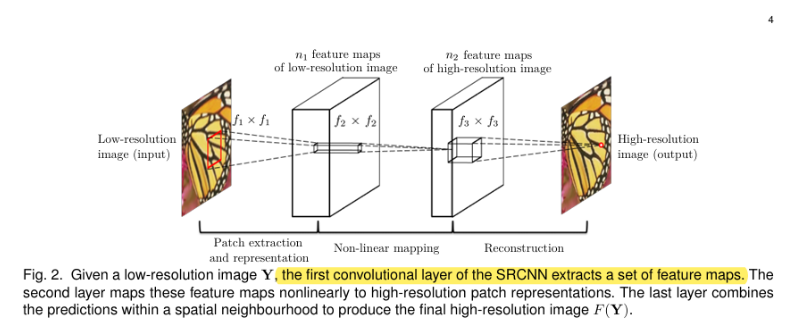
The following shows the number of filters and the kernel sizes of the most general SRCNN architecture.
- n1 = 64
- n2 = 32
- f1xf1 = 9×9
- f2xf2 = 1×1
- f3xf3 = 5×5
#### Non-linear mapping:

- After the first layer extracts n1​-dimensional features for each patch, the second operation maps these vectors to n2​-dimensional ones. This is achieved by applying n2​ filters with a spatial support of  f2 x f2.
- F2(Y)=max(0,W2∗F1(Y)+B2), where:
	- - W2 contains n2​ filters of size n1 x f2 x f2
	- B2 is n2​-dimensional.
#### Reconstruction:
- The predicted overlapping high-resolution patches are traditionally averaged to produce the final full image.
- F(Y)=W3∗F2(Y)+B3, where:
	- W3 corresponds to c filters of size n2 x f3 x f3.
	- B3 is a c-dimensional vector.


### Loss function used:

**Mean Squared Error loss function**
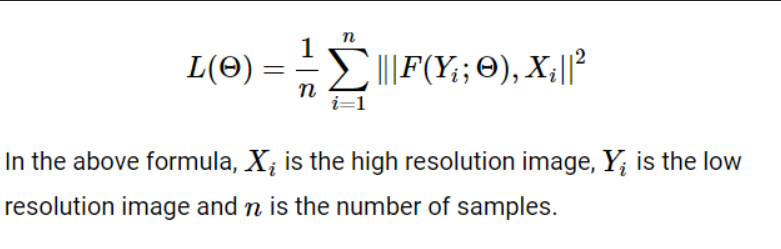

 **PSNR (Peak Signal to Noise Ratio)**:
- **PSNR** is a commonly used metric in image processing tasks, including image super-resolution.
- It measures the similarity between the images generated by the model and the ground truth high-resolution images.
- **A higher PSNR value indicates better performance,** with higher values corresponding to images that are closer in quality to the ground truth.
- PSNR is measured in decibels (dB).
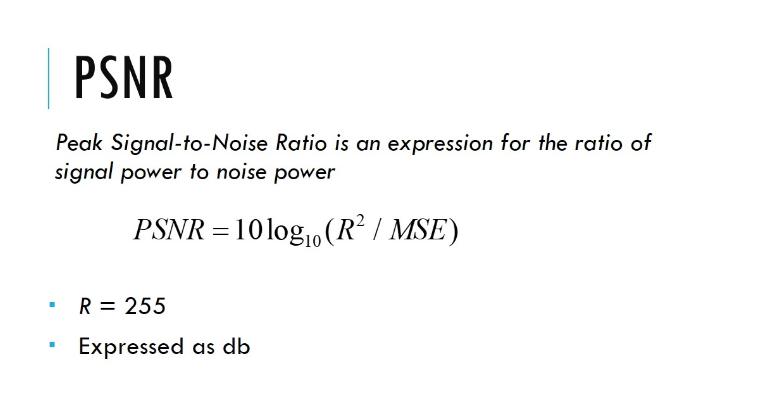


#### Alternative metrics:
**SSIM (Structural Similarity Index Measure)**:
SSIM is another metric used to evaluate image quality, particularly in tasks where human perception of image quality is important. It measures the similarity between two images, taking into account **luminance, contrast, and structure.** SSIM values range from -1 to 1, **where 1 indicates perfect similarity.**

**MSSIM (Mean Structural Similarity Index Measure)**:
MSSIM is a variation of SSIM that computes the average SSIM value across multiple patches of the images. It provides a more comprehensive measure of the overall similarity between two images. Similar to SSIM, MSSIM values range from -1 to 1, with **1 indicating perfect similarity.**



# Pre-trained SRCNN 

Before we begin, ensure you have PyTorch installed. You can install it using pip:

In [ ]:
# !pip install torch torchvision pillow

Import the necessary libraries:

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import os
import numpy as np

## The SRCNN model consists of three convolutional layers.
 Here's a breakdown of the model architecture:

- Convolutional Layer 1: This layer uses a 9x9 kernel to extract features from the input image. It outputs 64 feature maps.
- Convolutional Layer 2: This layer uses a 5x5 kernel to further refine the features. It outputs 32 feature maps.
- Convolutional Layer 3: This layer uses a 5x5 kernel to reconstruct the high-resolution image from the refined features.

The ReLU activation function is used after the first two convolutional layers to introduce non-linearity.

**Three-Layer Convolutional Neural Network:**

The model consists of three convolutional layers:
First Layer: Extracts overlapping patches from the input image and represents them as high-dimensional vectors (feature maps).
Second Layer: Maps these high-dimensional vectors to another set of high-dimensional vectors. This step introduces non-linearity.
Third Layer: Aggregates the high-dimensional vectors to produce the final high-resolution image.

In [ ]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

To use the model, we need to instantiate it. 

In the original SRCNN paper, the authors used grayscale images for their experiments, which is why the number of channels (num_channels) is set to 1 in the model implementation. This simplifies the training process and focuses on the luminance channel, which is often the most significant component in terms of perceived image quality. 

- For grayscale images, we can use num_channels=1. 

For convenience, we can use a pre-trained SRCNN model instead of training one from scratch. Here, I have directly taken a trained SRCNN model from a GitHub repository and loaded it for inference. This saves time and computational resources.

Reference to the pre-trained model: [SRCNN GitHub Repository](https://github.com/yjn870/SRCNN-pytorch)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_SRCNN = SRCNN().to(device)
model_SRCNN.load_state_dict(torch.load('/kaggle/input/srcnn_x4/pytorch/srcnn_x4/1/srcnn_x4.pth', map_location=device))
model_SRCNN.eval()

In [ ]:
model_SRCNN.state_dict

## Understanding the YCbCr Color Space

- The YCbCr color space is widely used in image and video compression standards, such as JPEG and MPEG.

- It is derived from the RGB color space and separates an image into its luminance and chrominance components.

- Y (Luminance): The Y component represents the brightness or grayscale information of the image.
***It is a weighted sum of the RGB values: Y=0.299R+0.587G+0.114B***

- Cb (Chroma Blue): It indicates how much blue is present in the image relative to the luminance.
**Cb=128−0.168736R−0.331264G+0.5B**

- Cr (Chroma Red): It indicates how much red is present in the image relative to the luminance.
**Cr=128+0.5R−0.418688G−0.081312B**




**The luminance channel is the most critical component for perceived image quality.**

Enhancements to the Y channel result in noticeable improvements in sharpness and detail.

***The SRCNN model focuses on enhancing this channel to improve the overall image resolution and quality.***

## Some Helper functions: utils.py
1. Load Image
The load_image function loads an image and converts it to the YCbCr color space, which separates the luminance (Y) from the chrominance (Cb and Cr) components. This is useful because the SRCNN model primarily enhances the luminance channel.


2. Preprocess Image
The preprocess_image function converts the luminance (Y) channel to a tensor and adds a batch dimension, which is required for input to the SRCNN model.


3. Postprocess Image
The postprocess_image function converts the output tensor from the SRCNN model back to a PIL image, ensuring the pixel values are clamped between 0 and 1.

4. Denormalize
The denormalize function scales the tensor values back to their original range. This function is useful if the tensor was normalized before processing.

5. Upscale Image
The upscale_image function takes a low-resolution image (split into Y, Cb, and Cr channels), processes the Y channel through the SRCNN model, and then combines the upscaled Y channel with the upscaled Cb and Cr channels to produce the final high-resolution image.

6. Save Image
The save_image function saves the final high-resolution image to a specified file path.

In [ ]:
# helper functions
def load_image(image_path):
    img = Image.open(image_path).convert('YCbCr')
    y, cb, cr = img.split()
    return y, cb, cr

def preprocess_image(img):
    img = transforms.ToTensor()(img)
    img = img.unsqueeze(0)  # Add batch dimension
    return img

def postprocess_image(tensor):
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor.clamp(0, 1)  # Ensure the values are between 0 and 1
    img = transforms.ToPILImage()(tensor)
    return img


def denormalize(tensor):
    return tensor.mul(0.5).add(0.5).clamp(0, 1)

def upscale_image(model, low_res_image):
    y, cb, cr = low_res_image
    y = preprocess_image(y).to(device)
    
    with torch.no_grad():
        y_upscaled = model(y).squeeze(0).cpu()
    
    y_upscaled = y_upscaled.clamp(0, 1)  # Ensure the values are between 0 and 1
    y_upscaled = transforms.ToPILImage()(y_upscaled)
    cb_upscaled = cb.resize(y_upscaled.size, Image.BICUBIC)
    cr_upscaled = cr.resize(y_upscaled.size, Image.BICUBIC)

    upscaled_image = Image.merge('YCbCr', [y_upscaled, cb_upscaled, cr_upscaled]).convert('RGB')
    return upscaled_image


def save_image(img, path):
    img.save(path)

To visually compare the low-resolution, high-resolution, and upscaled images, we can use the display_images function. 

We need to read the images from the specified paths, convert them to RGB format, and displaythem side by side using Matplotlib.

In [ ]:
def display_images(low_res_path, high_res_path, upscaled_path):
    low_res_img = Image.open(low_res_path).convert('RGB')
    high_res_img = Image.open(high_res_path).convert('RGB')
    upscaled_img = Image.open(upscaled_path).convert('RGB')
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title('Low Resolution')
    plt.imshow(low_res_img)
    
    plt.subplot(1, 3, 2)
    plt.title('High Resolution')
    plt.imshow(high_res_img)
    
    plt.subplot(1, 3, 3)
    plt.title('Upscaled')
    plt.imshow(upscaled_img)
    
    plt.show()

**The process_and_display_images function processes a specified number of images from directories containing low-resolution and high-resolution images.**

***It then uses the SRCNN model to upscale the low-resolution images, saves the upscaled images, and displays the low-resolution, high-resolution, and upscaled images side by side for comparison using the function above.***

In [ ]:
def process_and_display_images(model , low_res_dir, high_res_dir, output_dir, num_images_to_process=6):
    os.makedirs(output_dir, exist_ok=True)
    processed_count = 0

    for img_name in os.listdir(low_res_dir):
        if processed_count >= num_images_to_process:
            break
        
        low_res_path = os.path.join(low_res_dir, img_name)
        high_res_path = os.path.join(high_res_dir, img_name)
        
        y, cb, cr = load_image(low_res_path)
        upscaled_img = upscale_image(model,  (y, cb, cr))
        
        save_path = os.path.join(output_dir, img_name)
        save_image(upscaled_img, save_path)
        
        print(f'Processed {img_name}')
        processed_count += 1
        
        # Display the images
        display_images(low_res_path, high_res_path, save_path)

In [ ]:
# Directory paths
val_low_res_dir = '/kaggle/input/image-super-resolution/dataset/val/low_res'
val_high_res_dir = '/kaggle/input/image-super-resolution/dataset/val/high_res'
output_dir = '/kaggle/working/upscaled_images'

os.makedirs(output_dir, exist_ok=True)

## Using Pretrained SRCNN on some test images:

In [ ]:
process_and_display_images(model_SRCNN, val_low_res_dir, val_high_res_dir, output_dir, num_images_to_process=10)

### Not so good. Right? Let's go and finetune our model.

# Finetuning the Model - SRCNN_Finetuned

## ImageDataset class 

To effectively work with large sets of images for super-resolution tasks, we can create a custom dataset class using PyTorch's Dataset class. This custom dataset will handle loading, transforming, and returning low-resolution and high-resolution image pairs along with their chrominance components.


The ImageDataset class is designed to load images from specified directories, convert them to the YCbCr color space, and apply necessary transformations.


**Get Item (__getitem__ method):**
<pre>
Parameters:
- idx: Index of the image to be fetched.

Operations:
- Constructs the full paths for the low-resolution and high-resolution images using the index.
- Opens the images and converts them to the YCbCr color space.
- Splits the images into their Y, Cb, and Cr components.
- Applies the specified transformations (if any) to the Y, Cb, and Cr components.

Returns:
- A tuple containing the transformed Y, Cb, and Cr components for both low-resolution and high-resolution images.
</pre>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, low_res_dir, high_res_dir, transform=None):
        self.low_res_dir = low_res_dir
        self.high_res_dir = high_res_dir
        self.low_res_images = os.listdir(low_res_dir)
        self.high_res_images = os.listdir(high_res_dir)
        self.transform = transform

    def __len__(self):
        return len(self.low_res_images)

    def __getitem__(self, idx):
        low_res_image_path = os.path.join(self.low_res_dir, self.low_res_images[idx])
        high_res_image_path = os.path.join(self.high_res_dir, self.high_res_images[idx])

        low_res_image = Image.open(low_res_image_path).convert('YCbCr')
        high_res_image = Image.open(high_res_image_path).convert('YCbCr')

        y_low, cb_low, cr_low = low_res_image.split()
        y_high, cb_high, cr_high = high_res_image.split()

        if self.transform:
            y_low = self.transform(y_low)
            y_high = self.transform(y_high)
            cb_low = self.transform(cb_low)
            cr_low = self.transform(cr_low)
            cb_high = self.transform(cb_high)
            cr_high = self.transform(cr_high)

        return y_low, y_high, cb_low, cr_low, cb_high, cr_high

transform = transforms.Compose([
    transforms.ToTensor()
])


Then just simply create datasets and dataloaders just like the always
traditional pytorch method.

In [ ]:
train_dataset = ImageDataset('/kaggle/input/image-super-resolution/dataset/train/low_res', '/kaggle/input/image-super-resolution/dataset/train/high_res', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = ImageDataset('/kaggle/input/image-super-resolution/dataset/val/low_res', '/kaggle/input/image-super-resolution/dataset/val/high_res', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


To ensure that our custom dataset and data loaders are working correctly, we can create a testing function that loads a batch of images, processes them, and displays the low-resolution and high-resolution images side by side.

## Datasets and Dataloaders:

**The denormalize function converts the Y, Cb, and Cr components from tensor format back to PIL images, merges them into a single YCbCr image, and then converts it to RGB format for display.**

In [ ]:
# testing the dataloaders

import numpy as np
from PIL import Image

def denormalize(y, cb, cr):
    '''
    converts the YCbCr into PIL image format then into RGB format for displaying
    '''
    y = y.squeeze(0).numpy()  # Remove the channel dimension for Y
    y = np.clip(y * 255, 0, 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
    
    # repeat the same fr this two aswell
    cb = cb.squeeze(0).numpy()
    cb = np.clip(cb * 255, 0, 255).astype(np.uint8)
    
    cr = cr.squeeze(0).numpy()
    cr = np.clip(cr * 255, 0, 255).astype(np.uint8)

    y_img = Image.fromarray(y, mode='L')
    cb_img = Image.fromarray(cb, mode='L')
    cr_img = Image.fromarray(cr, mode='L')

    ycbcr_img = Image.merge('YCbCr', (y_img, cb_img, cr_img))
    rgb_img = ycbcr_img.convert('RGB')
    return rgb_img




import matplotlib.pyplot as plt

def test_dataloader(dataloader, dataloader_name):
    print(f"Testing {dataloader_name}:")
    for i, (y_low, y_high, cb_low, cr_low, cb_high, cr_high) in enumerate(dataloader):
        if i == 1:  # Display only the first batch
            break
        for j in range(y_low.size(0)):
            print(f"Shape of y_low[{j}]: {y_low[j].shape}")  # Print shape of y_low tensor
            print(f"Shape of y_high[{j}]: {y_high[j].shape}")  # Print shape of y_high tensor

            low_res_img = denormalize(y_low[j], cb_low[j], cr_low[j])
            high_res_img = denormalize(y_high[j], cb_high[j], cr_high[j])

            # Display the images
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title('Low Resolution')
            plt.imshow(low_res_img)

            plt.subplot(1, 2, 2)
            plt.title('High Resolution')
            plt.imshow(high_res_img)

            plt.show()



Testing the train loader and the val loader both 

In [ ]:
# Test train_loader
test_dataloader(train_loader, "train_loader")

In [ ]:
test_dataloader(val_loader, "val_loader")

## Training Loop:

Here comes the boss moment now: Training LOOP / Finetuning the model



The train_model function trains the SRCNN model using the provided data loaders, criterion, and optimizer. It also evaluates the model on the validation set after each epoch.

We use the Mean Squared Error (MSE) loss function (nn.MSELoss) to measure the difference between the predicted high-resolution image and the ground truth high-resolution image.
MSE is suitable for image reconstruction tasks because it penalizes large errors more than small errors, encouraging the model to produce images close to the ground truth.

Training Data:

We use pairs of low-resolution (LR) and high-resolution (HR) images.
Data is loaded using PyTorch's DataLoader which batches the data and handles shuffling.

In [ ]:
NUM_EPOCHS = 20

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


def psnr(img1, img2):
    '''
    It compares the original and reconstructed images, providing a measure of similarity. 
    A higher PSNR indicates better quality.
    '''
    mse = ((img1 - img2) ** 2).mean()
    if mse == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))


# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS):
    
    '''
    Trains the SRCNN model using the provided training and validation data loaders.

    Args:
        model (nn.Module): The SRCNN model to be trained.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (nn.Module): Loss function to be used for training (e.g., nn.MSELoss).
        optimizer (torch.optim.Optimizer): Optimizer for model parameters (e.g., optim.Adam).
        num_epochs (int): Number of epochs to train the model. Default is 5.

    Returns:
        nn.Module: The trained SRCNN model.
    
    '''
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_psnr = 0.0

        for y_low, y_high, _, _, _, _ in train_loader:
            y_low, y_high = y_low.to(device), y_high.to(device)

            optimizer.zero_grad()
            outputs = model(y_low)
            loss = criterion(outputs, y_high)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * y_low.size(0)
            running_psnr += psnr(outputs.cpu().detach().numpy(), y_high.cpu().detach().numpy()) * y_low.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_psnr = running_psnr / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_psnr = 0.0
        with torch.no_grad():
            for y_low, y_high, _, _, _, _ in val_loader:
                y_low, y_high = y_low.to(device), y_high.to(device)

                outputs = model(y_low)
                loss = criterion(outputs, y_high)

                val_loss += loss.item() * y_low.size(0)
                val_psnr += psnr(outputs.cpu().numpy(), y_high.cpu().numpy()) * y_low.size(0)

        val_loss /= len(val_loader.dataset)
        val_psnr /= len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train PSNR: {epoch_psnr:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val PSNR: {val_psnr:.4f}')

    print('Training complete')
    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_SRCNN_finetuned = model_SRCNN.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_SRCNN_finetuned.parameters(), lr=0.001)

In [ ]:
model_SRCNN_finetuned

## **Finetune the Model**

In [ ]:
model_SRCNN_finetuned = train_model(model_SRCNN_finetuned, train_loader, val_loader, criterion, optimizer)



In [ ]:
# Directory paths
val_low_res_dir = '/kaggle/input/image-super-resolution/dataset/val/low_res'
val_high_res_dir = '/kaggle/input/image-super-resolution/dataset/val/high_res'
output_dir_finetuned = '/kaggle/working/upscaled_images_finetuned'

os.makedirs(output_dir, exist_ok=True)


## Test on Images:

In [ ]:
process_and_display_images(model_SRCNN_finetuned, val_low_res_dir, val_high_res_dir, output_dir_finetuned, num_images_to_process=3)

better than the previous ? kind of. 

In [ ]:
# Save the fine-tuned model

torch.save(model_SRCNN_finetuned.state_dict(), 'model_SRCNN_finetuned.pth')

## Compare the outputs of finetuned vs unfinetuned model:

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def load_images_with_filenames(folder):
    images = {}
    for filename in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).convert('RGB')
        images[filename] = img
    return images

def compare_model_outputs(unfinetuned_folder, finetuned_folder, num_images=5):
    unfinetuned_images = load_images_with_filenames(unfinetuned_folder)
    finetuned_images = load_images_with_filenames(finetuned_folder)
    
    common_filenames = set(unfinetuned_images.keys()) & set(finetuned_images.keys())
    
    for i, filename in enumerate(sorted(common_filenames)):
        if i >= num_images:
            break
        
        plt.figure(figsize=(20, 10))
                
        plt.subplot(1, 2, 1)
        plt.title('Unfinetuned Output')
        plt.imshow(unfinetuned_images[filename])
        
        plt.subplot(1, 2, 2)
        plt.title('Finetuned Output')
        plt.imshow(finetuned_images[filename])
        
        plt.show()



unfinetuned_folder = '/kaggle/working/upscaled_images'
finetuned_folder = '/kaggle/working/upscaled_images_finetuned'


compare_model_outputs(unfinetuned_folder, finetuned_folder, num_images=3)


# End Notes:

This notebook covered the just the basics of using the SRCNN model for image super-resolution, including how to load and preprocess data, train the model, and finetune it on a custom dataset. 

You should now have a solid foundation to further explore and improve upon super-resolution techniques using SRCNN. 

Next one on Super Resolution is SRGAN and ESRGAN. Do check those out! 

Happy experimenting!